ep  200 | tot 3.674e-03 | pde 3.426e-04 | wave 7.190e-03 | left 2.819e-03 | right 8.643e-07
ep  400 | tot 5.525e-04 | pde 1.571e-04 | wave 4.101e-03 | left 3.020e-04 | right 1.705e-07
ep  600 | tot 1.458e-03 | pde 9.724e-05 | wave 2.266e-03 | left 5.733e-05 | right 1.876e-07
ep  800 | tot 1.918e-04 | pde 9.160e-06 | wave 1.481e-04 | left 4.126e-05 | right 7.416e-08
ep 1000 | tot 7.630e-03 | pde 5.824e-05 | wave 1.387e-04 | left 6.885e-03 | right 1.214e-06
ep 1200 | tot 5.967e-04 | pde 1.520e-05 | wave 5.001e-05 | left 4.594e-04 | right 1.373e-07
ep 1400 | tot 5.081e-05 | pde 3.168e-06 | wave 3.777e-05 | left 6.733e-06 | right 6.649e-08
ep 1600 | tot 4.246e-05 | pde 2.861e-06 | wave 2.976e-05 | left 5.292e-06 | right 5.498e-08
ep 1800 | tot 3.620e-05 | pde 2.573e-06 | wave 2.437e-05 | left 4.315e-06 | right 5.603e-08
ep 2000 | tot 3.309e-05 | pde 2.114e-06 | wave 2.097e-05 | left 3.878e-06 | right 5.132e-08


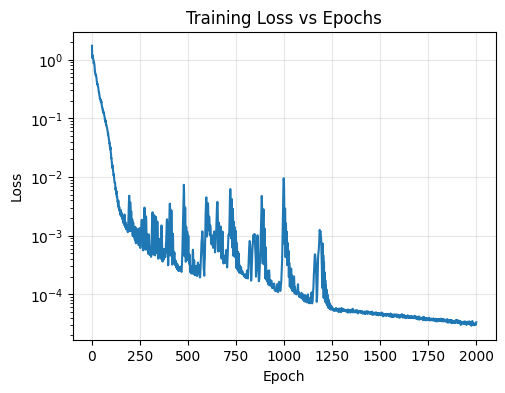

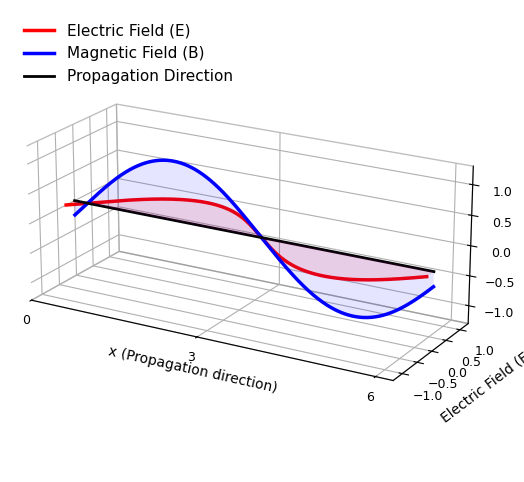

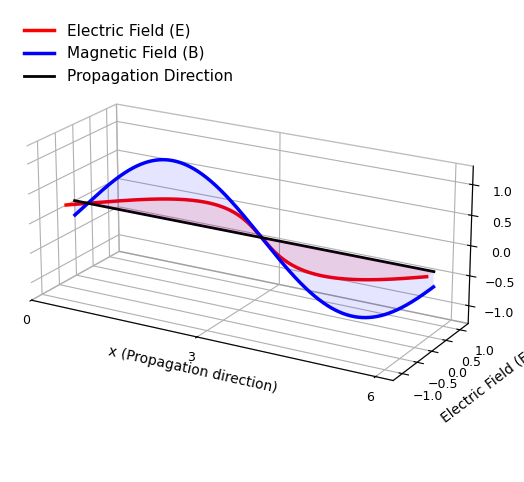

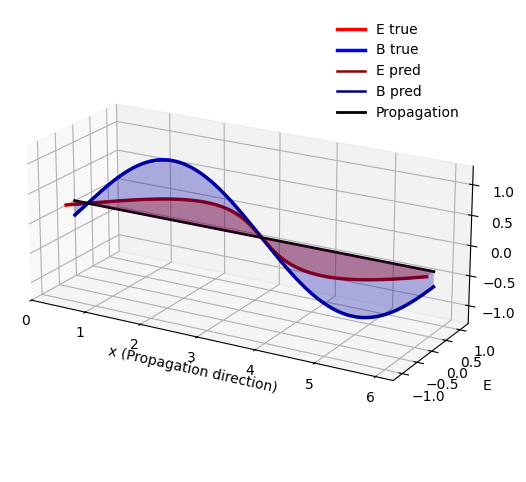

In [4]:
# Maxwell PINN
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Domain
Lx = 2*np.pi
T  = 2*np.pi
xmin, xmax = 0.0, Lx
tmin, tmax = 0.0, T
c = 1.0               # wave speed
k = 1.0             # choose k, ω explicitly
omega = c*k

# True traveling wave (right-going)
def true_E(x, t): return torch.sin(k*x - omega*t)
def true_B(x, t): return (1.0/c) * torch.sin(k*x - omega*t)

# Cosine activation
class CosineActivation(nn.Module):
    def forward(self, x): return torch.cos(x)

# Network: (x,t) -> (E,B)
class MaxwellPINN(nn.Module):
    def __init__(self, layers=(2,128,128,128,128,128,2)):   # + one 64 layer
        super().__init__()
        net = []
        for i in range(len(layers)-1):
            net.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                net.append(CosineActivation())
        self.net = nn.Sequential(*net)
    def forward(self, X):
        return self.net(X)

model = MaxwellPINN().to(device)


def left_bc_driven(model, xmin, tmin, tmax, omega, c=1.0, N=512):
    t = torch.rand(N,1, device=device)*(tmax - tmin) + tmin
    X = torch.cat([torch.full_like(t, xmin), t], 1)

    E, B = model(X).split(1,1)

    # Correct traveling-wave boundary (phase-matched)
    phase = -omega * t               # k*x = 0 at xmin
    E_left = torch.sin(phase)
    B_left = (1.0/c) * torch.sin(phase)

    return ((E - E_left)**2).mean() + ((B - B_left)**2).mean()

def right_outflow_loss(model, xmax, tmin, tmax, c=1.0, N=512):
    t = torch.rand(N,1, device=device)*(tmax - tmin) + tmin
    X = torch.cat([torch.full_like(t, xmax), t], 1)
    E, B = model(X).split(1,1)
    Fm = E - c*B          # no incoming left-going wave
    return (Fm**2).mean()

#Residuals
def maxwell_residuals(model, x, t):
    # x and t already have requires_grad=True from the calling function
    X_full = torch.cat([x, t], dim=1)
    E, B = model(X_full).split(1, dim=1)

    dE_dx = torch.autograd.grad(E, x, torch.ones_like(E), retain_graph=True, create_graph=True)[0]
    dB_dt = torch.autograd.grad(B, t, torch.ones_like(B), retain_graph=True, create_graph=True)[0]
    dB_dx = torch.autograd.grad(B, x, torch.ones_like(B), retain_graph=True, create_graph=True)[0]
    dE_dt = torch.autograd.grad(E, t, torch.ones_like(E), retain_graph=True, create_graph=True)[0]

    r1 = dE_dx + dB_dt
    r2 = dB_dx + (1.0/(c**2))*dE_dt


    return r1, r2, E, B

#Test with wave equation (second derivatives)

def wave_residuals(model, x, t, c=1.0):
    X = torch.cat([x, t], 1).requires_grad_(True)
    E, B = model(X).split(1,1)

    dE_dx = torch.autograd.grad(E, x, torch.ones_like(E), retain_graph=True, create_graph=True)[0]
    dB_dx = torch.autograd.grad(B, x, torch.ones_like(B), retain_graph=True, create_graph=True)[0]
    d2E_dx2 = torch.autograd.grad(dE_dx, x, torch.ones_like(dE_dx), retain_graph=True, create_graph=True)[0]
    d2B_dx2 = torch.autograd.grad(dB_dx, x, torch.ones_like(dB_dx), retain_graph=True, create_graph=True)[0]

    dE_dt = torch.autograd.grad(E, t, torch.ones_like(E), retain_graph=True, create_graph=True)[0]
    dB_dt = torch.autograd.grad(B, t, torch.ones_like(B), retain_graph=True, create_graph=True)[0]
    d2E_dt2 = torch.autograd.grad(dE_dt, t, torch.ones_like(dE_dt), retain_graph=True, create_graph=True)[0]
    d2B_dt2 = torch.autograd.grad(dB_dt, t, torch.ones_like(dB_dt), retain_graph=True, create_graph=True)[0]

    rE = d2E_dt2 - (c**2)*d2E_dx2
    rB = d2B_dt2 - (c**2)*d2B_dx2
    return rE, rB


    # Periodic BC in x: E,B(x±Lx,t) = E,B(x,t)

def periodic_loss(model, t_samp):
    # sample random x and use the provided t's
    x = torch.rand_like(t_samp, device=device)*(xmax - xmin) + xmin
    Xc = torch.cat([x,            t_samp], dim=1)
    Xp = torch.cat([x + Lx,       t_samp], dim=1)
    Xm = torch.cat([x - Lx,       t_samp], dim=1)

    Ec, Bc = model(Xc).split(1, 1)
    Ep, Bp = model(Xp).split(1, 1)
    Em, Bm = model(Xm).split(1, 1)

    return ((Ep - Ec)**2).mean() + ((Em - Ec)**2).mean() + \
           ((Bp - Bc)**2).mean() + ((Bm - Bc)**2).mean()

# Training loop (EPOCHS) — PDE + wave residual + boundary driving (no sine data inside)
def train_maxwell(model, n_epochs=2000, n_collocation=2048, lr=1e-3,
                  w_wave=0.5):

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []
    for epoch in range(1, n_epochs+1):
        opt.zero_grad()

        # interior collocation
        x = torch.rand(n_collocation,1,device=device,requires_grad=True)*(xmax-xmin)+xmin
        t = torch.rand(n_collocation,1,device=device,requires_grad=True)*(tmax-tmin)+tmin

        # first-order Maxwell residuals
        r1, r2, _, _ = maxwell_residuals(model, x, t)
        L_pde  = (r1**2).mean() + (r2**2).mean()

        # second-derivative wave residuals
        rE, rB = wave_residuals(model, x, t, c=c)
        L_wave = (rE**2).mean() + (rB**2).mean()

        t_samp = torch.rand(n_collocation,1,device=device)*(tmax-tmin)+tmin
        L_per  = periodic_loss(model, t_samp)

        # characteristic boundary conditions (no interior sine data)
        L_left  = left_bc_driven(model, xmin, tmin, tmax, omega, c=c, N=512)
        L_right = right_outflow_loss(model, xmax, tmin, tmax, c=c, N=512)

        # simple curriculum: start without wave residual, then add it
        if epoch < 600:
         L = L_pde + 1.0*L_left + 1.0*L_right + 1.0*L_per
        else:
         L = L_pde + 0.5*L_wave + 1.0*L_left + 1.0*L_right + 1.0*L_per

        L.backward()
        opt.step()

        # simple LR drop
        if epoch == 1200:
          for g in opt.param_groups:
              g['lr'] = 2e-4

        losses.append(float(L.item()))
        if epoch % 200 == 0:
           print(f"ep {epoch:4d} | tot {L.item():.3e} | pde {L_pde.item():.3e} | "f"wave {L_wave.item():.3e} | left {L_left.item():.3e} | right {L_right.item():.3e}")

    return losses

losses = train_maxwell(model, n_epochs=2000, n_collocation=2048, lr=1e-3, w_wave=0.5)

# Plots
t_star = 0.25
with torch.no_grad():
    x_plot = torch.linspace(0, Lx, 800, device=device).view(-1,1)
    t_plot = torch.zeros_like(x_plot)+t_star
    Etrue = true_E(x_plot,t_plot).cpu().numpy()
    Btrue = true_B(x_plot,t_plot).cpu().numpy()
    Epred,Bpred = model(torch.cat([x_plot,t_plot],1)).split(1,1)
    Epred = Epred.cpu().numpy(); Bpred = Bpred.cpu().numpy()

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(losses)
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training Loss vs Epochs"); plt.yscale("log"); plt.grid(alpha=0.3)


from mpl_toolkits.mplot3d import Axes3D

def _sample_model(x, t_star):

    X = torch.tensor(np.stack([x, np.full_like(x, t_star)], 1),
                     dtype=torch.float32, device=device)
    with torch.no_grad():
        EB = model(X).cpu().numpy()
    return EB[:,0], EB[:,1]

def plot_3d_em(t_star=0.0, *, use_model=True,
               E0=1.0, B0=1.0, wave_length=1.0, frequency=1.0,
               nx=400):

    k = 2*np.pi / wave_length
    omega = 2*np.pi * frequency
    x = np.linspace(0, 2*np.pi, nx)

    if use_model:
        E, B = _sample_model(x, t_star)
    else:
        E = E0*np.sin(k*x - omega*t_star)
        B = B0*np.sin(k*x - omega*t_star)


    Xs = np.array([x, x])
    Y_E = np.array([E, np.zeros_like(E)])
    Z_B = np.array([np.zeros_like(B), B])


    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(x, E, np.zeros_like(x), color='red',  linewidth=2.5, label='Electric Field (E)')
    ax.plot_surface(Xs, Y_E, np.zeros_like(Y_E), color='red',  alpha=0.1, shade=False)

    ax.plot(x, np.zeros_like(x), B, color='blue', linewidth=2.5, label='Magnetic Field (B)')
    ax.plot_surface(Xs, np.zeros_like(Z_B), Z_B, color='blue', alpha=0.1, shade=False)

    ax.plot([0, 2*np.pi], [0, 0], [0, 0], color='black', linewidth=2, label='Propagation Direction')

    ax.set_xlim([0, 2*np.pi]); ax.set_ylim([-1.3, 1.3]); ax.set_zlim([-1.3, 1.3])
    ax.set_box_aspect([2.5, 1, 1])
    ax.set_xticks(np.arange(0, 2*np.pi, 3))
    ax.set_yticks([-1.0, -0.5, 0, 0.5, 1.0])
    ax.set_zticks([-1.0, -0.5, 0, 0.5, 1.0])

    ax.set_xlabel("x (Propagation direction)")
    ax.set_ylabel("Electric Field (E)")
    ax.set_zlabel("Magnetic Field (B)")

    ax.tick_params(labelsize=9); ax.grid(True)
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.pane.fill = False
        axis.pane.set_edgecolor('gray')

    ax.legend(loc='upper left', fontsize=11, frameon=False)
    ax.view_init(elev=20, azim=-60)
    plt.show()

def plot_3d_compare(t_star=0.0, *,
                    E0=1.0, B0=1.0, wave_length=1.0, frequency=1.0,
                    nx=400):
    k = 2*np.pi / wave_length
    omega = 2*np.pi * frequency
    x = np.linspace(0, 2*np.pi, nx)

    # true
    E_true = E0*np.sin(k*x - omega*t_star)
    B_true = B0*np.sin(k*x - omega*t_star)

    # model
    E_pred, B_pred = _sample_model(x, t_star)


    Xs  = np.array([x, x])
    YE_t = np.array([E_true, np.zeros_like(E_true)])
    ZB_t = np.array([np.zeros_like(B_true), B_true])
    YE_p = np.array([E_pred, np.zeros_like(E_pred)])
    ZB_p = np.array([np.zeros_like(B_pred), B_pred])

    fig = plt.figure(figsize=(10,6)); ax = fig.add_subplot(111, projection='3d')


    ax.plot(x, E_true, np.zeros_like(x), color='red',  lw=2.5, label='E true')
    ax.plot_surface(Xs, YE_t, np.zeros_like(YE_t), color='red', alpha=0.12, shade=False)
    ax.plot(x, np.zeros_like(x), B_true, color='blue', lw=2.5, label='B true')
    ax.plot_surface(Xs, np.zeros_like(ZB_t), ZB_t, color='blue', alpha=0.12, shade=False)


    ax.plot(x, E_pred, np.zeros_like(x), color='darkred', lw=1.8, label='E pred')
    ax.plot_surface(Xs, YE_p, np.zeros_like(YE_p), color='darkred', alpha=0.20, shade=False)
    ax.plot(x, np.zeros_like(x), B_pred, color='navy', lw=1.8, label='B pred')
    ax.plot_surface(Xs, np.zeros_like(ZB_p), ZB_p, color='navy', alpha=0.20, shade=False)

    ax.plot([0, 2*np.pi], [0, 0], [0, 0], color='black', lw=2, label='Propagation')
    ax.set_xlim([0, 2*np.pi]); ax.set_ylim([-1.3, 1.3]); ax.set_zlim([-1.3, 1.3])
    ax.set_box_aspect([2.5, 1, 1])
    ax.set_xlabel("x (Propagation direction)"); ax.set_ylabel("E"); ax.set_zlabel("B")
    ax.legend(frameon=False); ax.view_init(elev=20, azim=-60); plt.show()


# PINN snapshot
plot_3d_em(t_star=0.25, use_model=True)

# Analytic-only (match training k)
plot_3d_em(
    t_star=0.25,
    use_model=False,
    wave_length=2*np.pi / k,       # <- use k from the top
    frequency=k / (2*np.pi)
)

# Side-by-side overlay (match training k)
plot_3d_compare(
    t_star=0.25,
    wave_length=2*np.pi / k,       # <- use k
    frequency=k / (2*np.pi)
)